## Benchmark 6: OLS model structured bootstrap resampling
Now that we have a resampling strategy that gives us at least some confidence that our internal benchmarking scores could be reflective of what will happened when we submit to the public leaderboard. Let's start working on the model. The first thing I want to try is another shot at the OLS model. Firstly, to see if we can make any clever improvements. But, mostly to generalize the functions written to resample, forecast and score the naive model.
1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Load & inspect](#load_inspect)
3. [Helper functions](#helper_functions)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

<a name="load_inspect"></a>
### 2. Load & inspect

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
import functions.data_manipulation_functions as data_funcs

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import RANSACRegressor

print(f'Python: {sys.version}')
print()
print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Numpy 1.23.5
Pandas 1.4.3


In [2]:
# Load parsed data
block_size = 33

output_file = f'{conf.DATA_PATH}/parsed_data/structured_bootstrap_blocksize{block_size}.npy'
timepoints = np.load(output_file)

print(f'Timepoints shape: {timepoints.shape}')
print()
print('Column types:')

for column in timepoints[0,0,0,0:]:
    print(f'\t{type(column)}')

print()
print(f'Example block:\n{timepoints[0,0,0:,]}')

Timepoints shape: (4, 3135, 33, 6)

Column types:
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>

Example block:
[[ 1.0010000e+03  1.5672960e+18  2.8848701e+00  1.1980000e+03
   1.0000000e+00 -1.2281170e-01]
 [ 1.0010000e+03  1.5698880e+18  3.0558431e+00  1.2690000e+03
   2.0000000e+00  1.7097300e-01]
 [ 1.0010000e+03  1.5725664e+18  2.9932332e+00  1.2430000e+03
   3.0000000e+00 -6.2609900e-02]
 [ 1.0010000e+03  1.5751584e+18  2.9932332e+00  1.2430000e+03
   4.0000000e+00  0.0000000e+00]
 [ 1.0010000e+03  1.5778368e+18  2.9690900e+00  1.2420000e+03
   5.0000000e+00 -2.4143200e-02]
 [ 1.0010000e+03  1.5805152e+18  2.9093256e+00  1.2170000e+03
   6.0000000e+00 -5.9764400e-02]
 [ 1.0010000e+03  1.5830208e+18  2.9332314e+00  1.2270000e+03
   7.0000000e+00  2.3905800e-02]
 [ 1.0010000e+03  1.5856992e+18  3.0001674e+00  1.2550000e+03
   8.0000000e+00  6.6936000e-02]
 [ 1.0010000e+03  1.5882

<a name="helper_functions"></a>
### 3. Helper functions

In [3]:
def two_point_smape(actual, forecast):
    '''Takes two datapoints and returns the SMAPE value for the pair'''

    # If SMAPE denominator is zero set SMAPE to zero
    if actual == 0 and forecast == 0:
        return 0

    # Calculate smape for forecast
    smape = abs(forecast - actual) / ((abs(actual) + abs(forecast)) / 2)
    
    return smape

In [4]:
def sample_parsed_data(timepoints, sample_size):
    '''Generates a random sample of sample_size from a random timepoint'''

    # Initialize random seed to make sure that output is differently random each call
    np.random.seed()

    # Pick random timepoint
    random_timepoint_index = np.random.choice(timepoints.shape[0], 1)
    timepoint = timepoints[random_timepoint_index][0]

    if sample_size == 'all':
        return timepoint

    # Pick n unique random county indexes to include in the sample
    random_county_indices = np.random.choice(timepoint.shape[0], sample_size, replace=False)

    # Use random indices to extract sample from timepoint
    sample = timepoint[random_county_indices]

    return sample

In [5]:
def make_forecasts(block, model_types, model_order):
    '''Uses specified model type and model order to forecast
    within block, one timepoint into the future. Also returns
    naive, 'carry-forward' prediction for the same datapoint 
    for comparison'''

    # Holder for SMAPE values
    block_predictions = {
        'model_type': [],
        'model_order': [],
        'MBD_predictions': [],
        'detrended_MBD_predictions': [],
        'MBD_inputs': [],
        'detrended_MBD_inputs': []
    }

    # Get prediction for naive control. Note: these are indexes
    # so model_order gets the model_order th element (zero anchored)
    block_predictions['model_type'].append('control')
    block_predictions['model_order'].append(model_order)
    block_predictions['MBD_predictions'].append(block[(model_order - 1), 2])
    block_predictions['detrended_MBD_predictions'].append(block[(model_order - 1), 5] + block[model_order, 2])

    # X input is model_order sequential integers
    x_input = list(range(model_order))

    # Y input is MBD values starting from the left
    # edge of the block, up to the model order. Note: this
    # is a slice so, the right edge is exclusive 
    y_input = list(block[:model_order, 2])
    detrended_y_input = list(block[:model_order, 5])

    block_predictions['MBD_inputs'].append(y_input)
    block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

    # Forecast X input is sequential integers starting
    # after the end of the X input. Note: we are only interested
    # in the first prediction here, but some statsmodels estimators
    # expect the same dim during forecast as they were fitted 
    forecast_x = list(range(model_order, (model_order * 2)))

    for model_type in model_types:

        if model_type == 'OLS':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit and predict raw data
            model = sm.OLS(y_input, sm.add_constant(x_input)).fit()
            prediction = model.predict(sm.add_constant(forecast_x))

            # Collect forecast
            block_predictions['MBD_predictions'].append(prediction[0])

            # Fit and predict detrended data
            model = sm.OLS(detrended_y_input, sm.add_constant(x_input)).fit()
            prediction = model.predict(sm.add_constant(forecast_x))

            # Collect forecast
            block_predictions['detrended_MBD_predictions'].append(prediction[0] + block[model_order, 2])

        if model_type == 'TS':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit Theil-Sen to raw data
            ts = stats.theilslopes(y_input, x_input)

            # Calculate forecast from Theil-Sen slope and intercept, add to results
            block_predictions['MBD_predictions'].append(ts[1] + ts[0] * forecast_x[0])

            # Fit Theil-Sen to detrended data
            ts = stats.theilslopes(detrended_y_input, x_input)

            # Calculate forecast from Theil-Sen slope and intercept, add to results
            block_predictions['detrended_MBD_predictions'].append((ts[1] + ts[0] * forecast_x[0]) + block[model_order, 2])

        if model_type == 'Seigel':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit Seigel to raw data
            ss = stats.siegelslopes(y_input, x_input)

            # Calculate forecast from Seigel slope and intercept, add to results
            block_predictions['MBD_predictions'].append(ss[1] + ss[0] * forecast_x[0])

            # Fit Theil-Sen to detrended data
            ss = stats.siegelslopes(detrended_y_input, x_input)

            # Calculate forecast from Seigel slope and intercept, add to results
            block_predictions['detrended_MBD_predictions'].append((ss[1] + ss[0] * forecast_x[0]) + block[model_order, 2])

        if model_type == 'ARIMA':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit ARIMA to raw data
            arima = sm.tsa.arima.ARIMA(y_input, order=(model_order,2,1), enforce_stationarity=False).fit()

            # Calculate forecast from ARIMA slope and intercept, add to results
            block_predictions['MBD_predictions'].append(arima.forecast()[0])

            # Fit ARIMA to detrended data
            arima = sm.tsa.arima.ARIMA(detrended_y_input, order=(model_order,2,1), enforce_stationarity=False).fit()

            # Calculate forecast from ARIMA slope and intercept, add to results
            block_predictions['detrended_MBD_predictions'].append(arima.forecast()[0] + block[model_order, 2])

        if model_type == 'Ridge':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit ridge to raw data
            ridge = Ridge()
            ridge.fit(np.array(x_input).reshape(-1, 1), np.array(y_input).reshape(-1, 1))

            # Get prediction, add to results
            block_predictions['MBD_predictions'].append(ridge.predict(np.array(forecast_x).reshape(-1, 1))[0][0])

            # Fit ridge to detrended data
            ridge = Ridge()
            ridge.fit(np.array(x_input).reshape(-1, 1), np.array(detrended_y_input).reshape(-1, 1))

            # Get prediction, add to results
            block_predictions['detrended_MBD_predictions'].append(ridge.predict(np.array(forecast_x).reshape(-1, 1))[0][0] + block[model_order, 2])

        if model_type == 'Huber':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit Huber to raw data
            huber = HuberRegressor(epsilon=1,max_iter=1000)
            huber.fit(np.array(x_input).reshape(-1, 1), np.array(y_input).reshape(-1, 1))

            # Get prediction, add to results
            block_predictions['MBD_predictions'].append(huber.predict(np.array(forecast_x).reshape(-1, 1))[0])

            # Fit huber to detrended data
            huber = HuberRegressor(epsilon=1,max_iter=1000)
            huber.fit(np.array(x_input).reshape(-1, 1), np.array(detrended_y_input).reshape(-1, 1))

            # Get prediction, add to results
            block_predictions['detrended_MBD_predictions'].append(huber.predict(np.array(forecast_x).reshape(-1, 1))[0] + block[model_order, 2])

        if model_type == 'Bayesian':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit Bayesian to raw data
            bayes = BayesianRidge()
            bayes.fit(np.array(x_input).reshape(-1, 1), np.array(y_input).reshape(-1, 1))

            # Get prediction, add to results
            block_predictions['MBD_predictions'].append(bayes.predict(np.array(forecast_x).reshape(-1, 1))[0])

            # Fit Bayesian to detrended data
            bayes = BayesianRidge()
            bayes.fit(np.array(x_input).reshape(-1, 1), np.array(detrended_y_input).reshape(-1, 1))

            # Get prediction, add to results
            block_predictions['detrended_MBD_predictions'].append(bayes.predict(np.array(forecast_x).reshape(-1, 1))[0] + block[model_order, 2])

        if model_type == 'RANSAC':

            # Add model type to results
            block_predictions['model_type'].append(model_type)

            # Add model order to results
            block_predictions['model_order'].append(model_order)

            block_predictions['MBD_inputs'].append(y_input)
            block_predictions['detrended_MBD_inputs'].append(detrended_y_input)

            # Fit RANSAC to raw data
            ransac = RANSACRegressor()
            ransac.fit(np.array(x_input).reshape(-1, 1), np.array(y_input).reshape(-1, 1))

            # Get prediction, add to results
            block_predictions['MBD_predictions'].append(ransac.predict(np.array(forecast_x).reshape(-1, 1))[0][0])

            # Fit RANSAC to detrended data
            ransac = RANSACRegressor()
            ransac.fit(np.array(x_input).reshape(-1, 1), np.array(detrended_y_input).reshape(-1, 1))

            # Get prediction, add to results
            block_predictions['detrended_MBD_predictions'].append(ransac.predict(np.array(forecast_x).reshape(-1, 1))[0][0] + block[model_order, 2])

    #print(f'Block predictions: {block_predictions}')    

    return block_predictions

In [6]:
def smape_score_models(sample, model_types, model_order):
    '''Takes a sample of blocks, makes forecast for each 
    and collects resulting SMAPE values'''

    # Holder for SMAPE values
    block_data = {
        'model_type': [],
        'model_order': [],
        'SMAPE_values': [],
        'detrended_SMAPE_values': [],
        'MBD_predictions': [],
        'detrended_MBD_predictions': [],
        'MBD_inputs': [],
        'detrended_MBD_inputs': [],
        'MBD_actual': []
    }

    for block_num in range(sample.shape[0]):

        # Get the forecasted value(s)
        block_predictions = make_forecasts(sample[block_num], model_types, model_order)

        # Collect predictions, input data and model info.
        for key, value in block_predictions.items():
            block_data[key].extend(value)

        # # Add model types and orders from the block results to the SMAPE values holder
        # block_smape_values['model_type'].extend(block_predictions['model_type'])
        # block_smape_values['model_order'].extend(block_predictions['model_order'])

        # # Add data
        # block_smape_values['MBD_predictions'].extend(block_predictions['MBD_predictions'])
        # block_smape_values['detrended_MBD_predictions'].extend(block_predictions['detrended_MBD_predictions'])
        # block_smape_values['MBD_inputs'].extend(block_predictions['MBD_inputs'])
        # block_smape_values['detrended_MBD_inputs'].extend(block_predictions['detrended_MBD_inputs'])

        # Get the true value and add to data
        actual_value = sample[block_num, model_order, 2]

        # Get and collect SMAPE value for models
        for value in block_predictions['MBD_predictions']:

            smape_value = two_point_smape(actual_value, value)
            block_data['SMAPE_values'].append(smape_value)
            block_data['MBD_actual'].append(actual_value)

        # Get and collect SMAPE value for models
        for value in block_predictions['detrended_MBD_predictions']:

            smape_value = two_point_smape(actual_value, value)
            block_data['detrended_SMAPE_values'].append(smape_value)
            #block_data['MBD_actual'].append(actual_value)

    return block_data

In [7]:
def bootstrap_smape_scores(timepoints, sample_num, sample_size, model_order, model_types):

    # Holder for sample results
    sample_data = {
        'sample': [],
        'model_type': [],
        'model_order': [],
        'SMAPE_values': [],
        'detrended_SMAPE_values': [],
        'MBD_predictions': [],
        'detrended_MBD_predictions': [],
        'MBD_inputs': [],
        'detrended_MBD_inputs': [],
        'MBD_actual': []
    }

    # Generate sample of random blocks from random timepoint
    sample = sample_parsed_data(timepoints, sample_size)

    # Do forecast and aggregate score across each block in sample
    result = smape_score_models(sample, model_types, model_order)

    for key, value in result.items():
        sample_data[key].extend(value)

    sample_data['sample'].extend([sample_num] * len(result['model_type']))

    return sample_data

In [8]:
def parallel_bootstrapped_smape(
    timepoints, 
    sample_num, 
    sample_size, 
    model_orders, 
    model_types
):
    
    # Holder for sample results
    data = {
        'sample': [],
        'model_type': [],
        'model_order': [],
        'SMAPE_values': [],
        'detrended_SMAPE_values': [],
        'MBD_predictions': [],
        'detrended_MBD_predictions': [],
        'MBD_inputs': [],
        'detrended_MBD_inputs': [],
        'MBD_actual': []
    }

    # Loop on model orders
    for model_order in model_orders:
        result = bootstrap_smape_scores(            
            timepoints, 
            sample_num, 
            sample_size, 
            model_order, 
            model_types
        )

        for key, value in result.items():
            data[key].extend(value)

    return data

In [9]:
# Ignore warnings from ARIMA parameter optimization
import warnings
warnings.filterwarnings('ignore')

num_samples = 180
sample_size = 100
model_orders = [4,6,8,10,12,14,16]
model_types = ['OLS', 'TS', 'Seigel', 'Ridge', 'Bayesian', 'RANSAC']#,'Huber', 'ARIMA']

# Fire up the pool
pool, result_objects = data_funcs.start_multiprocessing_pool()

for sample_num in range(sample_size):

    result = pool.apply_async(parallel_bootstrapped_smape,
        args = (
            timepoints, 
            sample_num, 
            sample_size, 
            model_orders, 
            model_types
        )
    )

    result_objects.append(result)

data = data_funcs.cleanup_bootstrapping_multiprocessing_pool(pool, result_objects)

print()

Starting processes for 18 CPUs (available - 2)



In [10]:
data_df = pd.DataFrame(data)
data_df.head(7)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,0,control,4,0.010133,0.019790,5.728510,5.559630,"[5.8029604, 5.8474278, 5.8396354, 5.7285099]","[0.05211640000000006, 0.04446740000000027, -0....",5.670756
1,0,OLS,4,0.013329,0.025192,5.746847,5.529676,"[5.8029604, 5.8474278, 5.8396354, 5.7285099]","[0.05211640000000006, 0.04446740000000027, -0....",5.670756
2,0,TS,4,0.019173,0.020488,5.780536,5.555751,"[5.8029604, 5.8474278, 5.8396354, 5.7285099]","[0.05211640000000006, 0.04446740000000027, -0....",5.670756
3,0,Seigel,4,0.022176,0.024024,5.797921,5.536138,"[5.8029604, 5.8474278, 5.8396354, 5.7285099]","[0.05211640000000006, 0.04446740000000027, -0....",5.670756
4,0,Ridge,4,0.015003,0.021117,5.756478,5.552259,"[5.8029604, 5.8474278, 5.8396354, 5.7285099]","[0.05211640000000006, 0.04446740000000027, -0....",5.670756
5,0,Bayesian,4,0.020147,0.023919,5.786168,5.536720,"[5.8029604, 5.8474278, 5.8396354, 5.7285099]","[0.05211640000000006, 0.04446740000000027, -0....",5.670756
6,0,RANSAC,4,0.009456,0.032328,5.617384,5.490346,"[5.8029604, 5.8474278, 5.8396354, 5.7285099]","[0.05211640000000006, 0.04446740000000027, -0....",5.670756


In [11]:
smape_scores_df = data_df.groupby(['sample', 'model_type', 'model_order'])[['SMAPE_values', 'detrended_SMAPE_values']].mean().mul(100)
smape_scores_df.rename(inplace=True, columns={'SMAPE_values': 'SMAPE_score', 'detrended_SMAPE_values': 'detrended_SMAPE_score'})
smape_scores_df.reset_index(inplace=True, drop=False)
smape_scores_df.head()

,sample,model_type,model_order,SMAPE_score,detrended_SMAPE_score
0,0,Bayesian,4,2.730729,2.215819
1,0,Bayesian,6,3.356728,1.946139
2,0,Bayesian,8,2.821746,1.051153
3,0,Bayesian,10,4.651579,1.183078
4,0,Bayesian,12,2.756476,0.964851


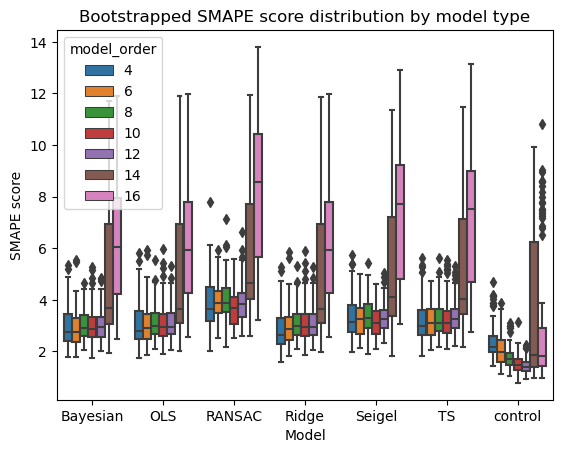

In [12]:
ax = sns.boxplot(
    data=smape_scores_df, 
    x='model_type',
    y='SMAPE_score',
    hue='model_order'
)

titles = ax.set(
    xlabel='Model', 
    ylabel='SMAPE score', 
    title='Bootstrapped SMAPE score distribution by model type'
)

# xticks = ax.set_xticks(ax.get_xticks()) # type: ignore
# xticklabels = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12) # type: ignore

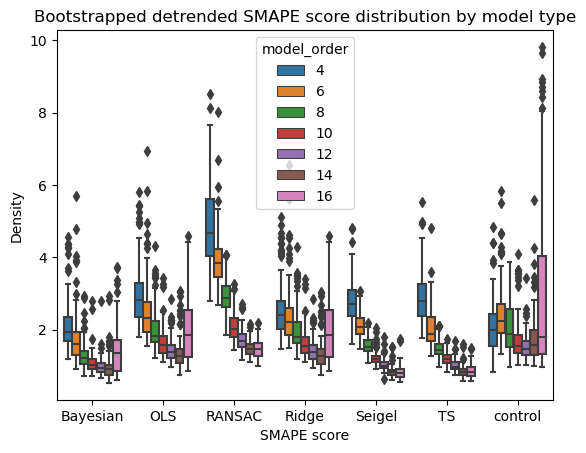

In [13]:
ax = sns.boxplot(
    data=smape_scores_df, 
    x='model_type',
    y='detrended_SMAPE_score',
    hue='model_order'
)

titles = ax.set(
    xlabel='SMAPE score', 
    ylabel='Density', 
    title='Bootstrapped detrended SMAPE score distribution by model type'
)

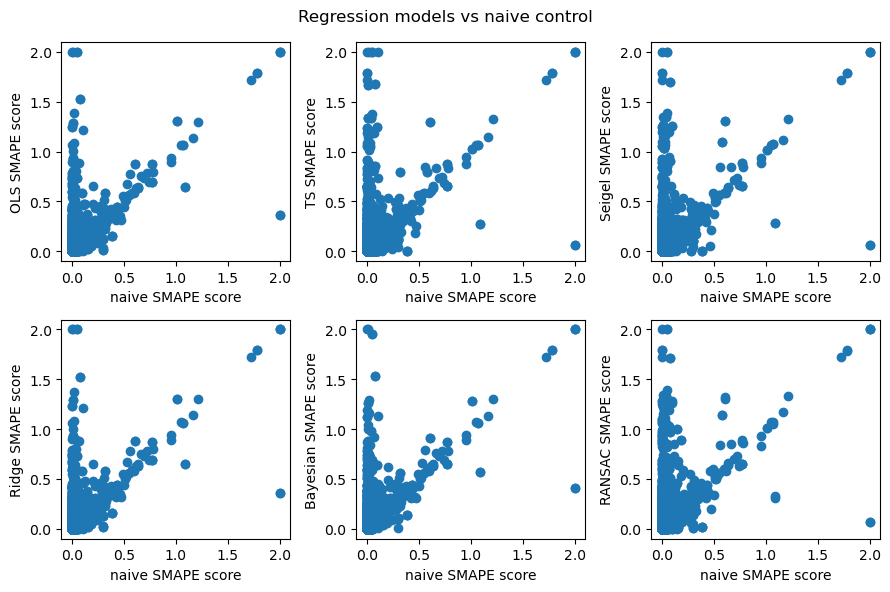

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(9,6))

ax[0,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'OLS') & (data_df['model_order'] == 16)]['SMAPE_values']
)
ax[0,0].set_xlabel('naive SMAPE score')
ax[0,0].set_ylabel('OLS SMAPE score')

ax[0,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['SMAPE_values']
)
ax[0,1].set_xlabel('naive SMAPE score')
ax[0,1].set_ylabel('TS SMAPE score')

ax[0,2].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['SMAPE_values']
)
ax[0,2].set_xlabel('naive SMAPE score')
ax[0,2].set_ylabel('Seigel SMAPE score')

ax[1,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Ridge') & (data_df['model_order'] == 16)]['SMAPE_values']
)
ax[1,0].set_xlabel('naive SMAPE score')
ax[1,0].set_ylabel('Ridge SMAPE score')

ax[1,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Bayesian') & (data_df['model_order'] == 16)]['SMAPE_values']
)
ax[1,1].set_xlabel('naive SMAPE score')
ax[1,1].set_ylabel('Bayesian SMAPE score')

ax[1,2].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'RANSAC') & (data_df['model_order'] == 16)]['SMAPE_values']
)
ax[1,2].set_xlabel('naive SMAPE score')
ax[1,2].set_ylabel('RANSAC SMAPE score')

plt.suptitle('Regression models vs naive control')
plt.tight_layout()

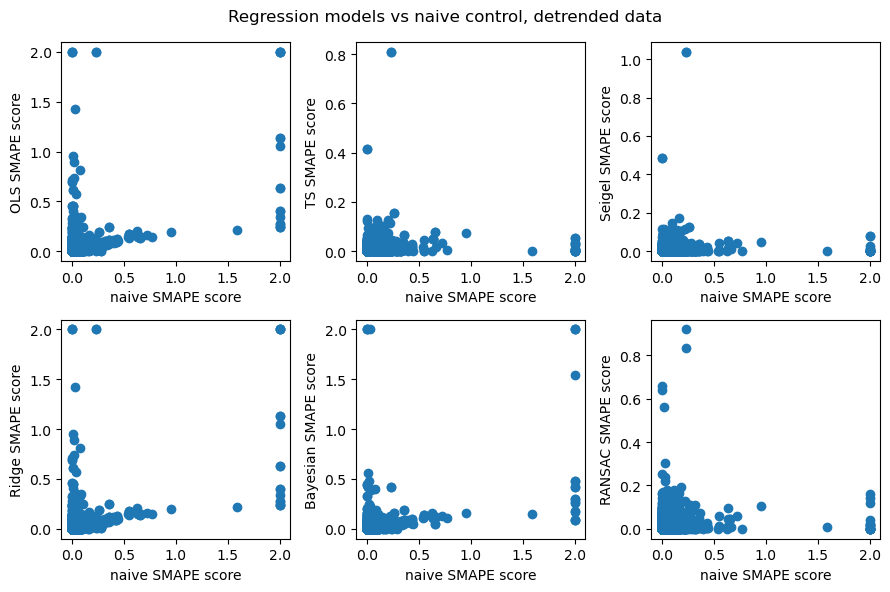

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(9,6))

ax[0,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    data_df[(data_df['model_type'] == 'OLS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)
ax[0,0].set_xlabel('naive SMAPE score')
ax[0,0].set_ylabel('OLS SMAPE score')

ax[0,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)
ax[0,1].set_xlabel('naive SMAPE score')
ax[0,1].set_ylabel('TS SMAPE score')

ax[0,2].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)
ax[0,2].set_xlabel('naive SMAPE score')
ax[0,2].set_ylabel('Seigel SMAPE score')

ax[1,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    data_df[(data_df['model_type'] == 'Ridge') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)
ax[1,0].set_xlabel('naive SMAPE score')
ax[1,0].set_ylabel('Ridge SMAPE score')

ax[1,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    data_df[(data_df['model_type'] == 'Bayesian') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)
ax[1,1].set_xlabel('naive SMAPE score')
ax[1,1].set_ylabel('Bayesian SMAPE score')

ax[1,2].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    data_df[(data_df['model_type'] == 'RANSAC') & (data_df['model_order'] == 16)]['detrended_SMAPE_values']
)
ax[1,2].set_xlabel('naive SMAPE score')
ax[1,2].set_ylabel('RANSAC SMAPE score')

plt.suptitle('Regression models vs naive control, detrended data')
plt.tight_layout()

Oooo, this plot is tantalizing - look at the blob in the upper left of both plots. We clearly have cases where the naive model does terribly and the regression model does better. If we could somehow pick the right model on the fly without having to see the actual forecast value we could improve this a lot. Part of me wants to spend some time on it, part of me thinks it's time to move on to ARIMA family models and GRUs/LSTMs...

The decision of what model to use would have to be made on the basis of descriptive stats on the input data or diagnostic data about the regression fit. I think the first thing to do would be to recover the samples that are producing the blob. Not sure that it's worth the time and effort.

In [25]:
mean_smape_score_df = smape_scores_df.groupby(['model_type', 'model_order'])[['SMAPE_score', 'detrended_SMAPE_score']].mean()
mean_smape_score_df.rename(inplace=True, columns={'SMAPE_score': 'mean_SMAPE_score', 'detrended_SMAPE_score': 'mean_detrended_SMAPE_score'})
mean_smape_score_df.reset_index(inplace=True, drop=False)
mean_smape_score_df.head()

,model_type,model_order,mean_SMAPE_score,mean_detrended_SMAPE_score
0,Bayesian,4,2.977509,2.150655
1,Bayesian,6,2.878167,1.767628
2,Bayesian,8,3.008004,1.286334
3,Bayesian,10,3.006625,1.088089
4,Bayesian,12,3.005082,0.990151


In [26]:
mean_smape_score_df.sort_values(by=['mean_SMAPE_score']).head(10)

,model_type,model_order,mean_SMAPE_score,mean_detrended_SMAPE_score
46,control,12,1.426612,1.526106
45,control,10,1.543686,1.727635
44,control,8,1.761078,2.098365
43,control,6,2.094914,2.465392
42,control,4,2.371136,2.071481
21,Ridge,4,2.871571,2.574692
1,Bayesian,6,2.878167,1.767628
22,Ridge,6,2.966014,2.413748
0,Bayesian,4,2.977509,2.150655
4,Bayesian,12,3.005082,0.990151


In [27]:
mean_smape_score_df.sort_values(by=['mean_detrended_SMAPE_score']).head(10)

,model_type,model_order,mean_SMAPE_score,mean_detrended_SMAPE_score
34,Seigel,16,7.328089,0.832010
40,TS,14,5.298188,0.839111
33,Seigel,14,5.305299,0.849018
41,TS,16,7.164968,0.863971
5,Bayesian,14,4.979822,0.971309
4,Bayesian,12,3.005082,0.990151
39,TS,12,3.312865,1.019502
32,Seigel,12,3.289779,1.035807
3,Bayesian,10,3.006625,1.088089
38,TS,10,3.258477,1.201654


In [32]:
winner = data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]
winner.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
4203,0,Seigel,16,0.002153,0.012481,1.709565,1.684729,"[1.8602749, 1.8551643, 1.844943, 1.8500537, 1....","[0.0, -0.005110600000000076, -0.01022129999999...",1.705888
4210,0,Seigel,16,0.215699,0.035416,0.944066,1.214583,"[0.89824563, 0.88421053, 0.88421053, 0.8842105...","[-0.12631577000000005, -0.014035099999999967, ...",1.172316
4217,0,Seigel,16,0.016732,0.005842,2.267422,2.216808,"[2.1730218, 2.1183546, 2.1320214, 2.1730218, 2...","[0.054667199999999916, -0.054667199999999916, ...",2.229797
4224,0,Seigel,16,0.035372,0.009153,3.301082,3.157312,"[3.8885665, 3.9030759, 3.8450377, 3.8450377, 3...","[-0.17411470000000007, 0.014509400000000117, -...",3.186344
4231,0,Seigel,16,0.087593,0.000000,4.156411,3.807615,"[2.6266418, 2.6266418, 2.6266418, 2.6266418, 2...","[0.0, 0.0, 0.0, 0.0, -0.03700049999999999, 0.0...",3.807615


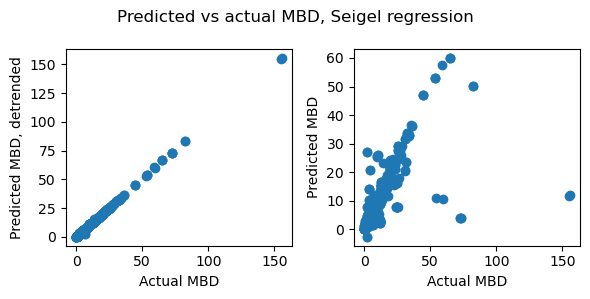

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions']
)
ax[0].set_xlabel('Actual MBD')
ax[0].set_ylabel('Predicted MBD, detrended')

ax[1].scatter(
    winner['MBD_actual'],
    winner['MBD_predictions']
)
ax[1].set_xlabel('Actual MBD')
ax[1].set_ylabel('Predicted MBD')

plt.suptitle('Predicted vs actual MBD, Seigel regression')
plt.tight_layout()